# Discretization plus Encoding

What shall we do with the variable after discretisation? should we use the buckets as a numerical variable? or should we use the intervals as categorical variable?

The answer is, you can do either.

If you are building decision tree based algorithms and the output of the discretisation are integers (each integer referring to a bin), then you can use those directly, as decision trees will pick up non-linear relationships between the discretised variable and the target.

If you are building linear models instead, the bins may not necessarily hold a linear relationship with the target. In this case, it may help improve model performance to treat the bins as categories and to one hot encoding, or target guided encodings like mean encoding, weight of evidence, or target guided ordinal encoding.

We can easily do so by combining feature-engine's discretisers and encoders.

## In this demo

We will perform equal frequency discretisation followed by ordered orginal encoding using the titanic dataset

If instead you would like to do weight of evidence or mean encoding, you need only replace the Feature-engine's encoder.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import OrdinalEncoder
from feature_engine.imputation import RandomSampleImputer

In [2]:
# load the the Titanic Dataset

usecols = ['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']

data = pd.read_csv('../../titanic.csv', usecols=usecols)

data.head()

pclass  survived     sex      age  sibsp  parch      fare embarked
0       1         1  female  29.0000      0      0  211.3375        S
1       1         1    male   0.9167      1      2  151.5500        S
2       1         0  female   2.0000      1      2  151.5500        S
3       1         0    male  30.0000      1      2  151.5500        S
4       1         0  female  25.0000      1      2  151.5500        S

In [3]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop("survived", axis=1),
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 7), (393, 7))

In [4]:
X_train.isnull().sum()

pclass        0
sex           0
age         175
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64

In [5]:
X_test.isnull().sum()

pclass       0
sex          0
age         88
sibsp        0
parch        0
fare         1
embarked     0
dtype: int64

## Imputation

In [6]:
# Random imputation

imputer = RandomSampleImputer(random_state=0, variables=["age", "embarked", "fare"])

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

## Discretization

In [7]:
# set up the equal frequency discretiser
# to encode variables we need them returned as objects for feature-engine

discretizer = EqualFrequencyDiscretiser(
    q=10, variables=['age', 'fare'], return_object=True)

# discretize
X_train = discretizer.fit_transform(X_train)
X_test = discretizer.transform(X_test)

In [8]:
X_train.dtypes

pclass       int64
sex         object
age         object
sibsp        int64
parch        int64
fare        object
embarked    object
dtype: object

In [9]:
X_train.head()

pclass     sex age  sibsp  parch fare embarked
501        2  female   0      0      1    5        S
588        2  female   0      1      1    6        S
402        2  female   5      1      0    4        C
1193       3    male   2      0      0    1        Q
686        3  female   2      0      0    1        Q

Text(0, 0.5, 'mean of survived')

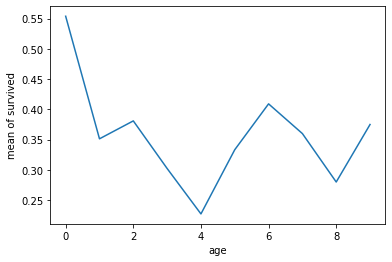

In [10]:
# let's explore if the bins have a linear relationship
# with the target:

y_test.groupby(X_test['age']).mean().plot()
plt.ylabel('mean of survived')

In [11]:
y_test.groupby(X_test['fare']).mean().plot()
plt.ylabel('mean of survived')

Text(0, 0.5, 'mean of survived')

Age does not show a monotonic relationship. Fare almost. Let's try to improve it with ordered ordinal encoding.

## Encoding

In [12]:
encoder = OrdinalEncoder(encoding_method = 'ordered')

X_train = encoder.fit_transform(X_train, y_train)

X_test = encoder.transform(X_test)

In [13]:
# in the map, we map bin to position

encoder.encoder_dict_

{'sex': {'male': 0, 'female': 1},
 'age': {1: 0, 7: 1, 2: 2, 4: 3, 3: 4, 9: 5, 8: 6, 5: 7, 6: 8, 0: 9},
 'fare': {0: 0, 3: 1, 2: 2, 4: 3, 1: 4, 5: 5, 7: 6, 6: 7, 8: 8, 9: 9},
 'embarked': {'S': 0, 'Q': 1, 'C': 2}}

Text(0, 0.5, 'mean of survived')

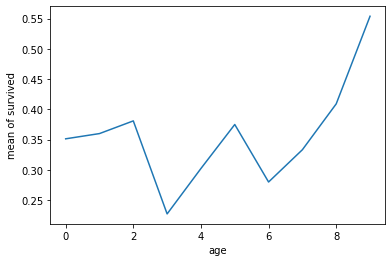

In [14]:
y_test.groupby(X_test['age']).mean().plot()
plt.ylabel('mean of survived')

In [15]:
y_test.groupby(X_test['fare']).mean().plot()
plt.ylabel('mean of survived')

Text(0, 0.5, 'mean of survived')

Now we obtained a monotonic(ish) relationship between Age and target. The encoding did not add much value to fare. We should use normal ordinal encoding, which comes out of the box with the discretizer.

**That is all for this demonstration. I hope you enjoyed the notebook, and see you in the next one.**